In [1]:
# Untuk mengimport library-library yang diperlukan torch, torchvision, matplotlib, dan dll
import torch 
import torchvision 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import matplotlib.pyplot as plt

In [2]:
n_epochs = 3 # untuk menentukan banyaknya epoch
batch_size_train = 64 # untuk menentukan proses pengulangan batch_size_train 
batch_size_test = 1000 # untuk menentukan banyaknya nilai batch size data test 
learning_rate = 0.01 # untuk menentukan nilai learning rate 
momentum = 0.5 # untuk menentukan nilai momentum 
log_interval = 10 

random_seed = 1 # untuk menyimpan nilai fungsi acak
torch.backends.cudnn.enabled = False 
torch.manual_seed(random_seed) # untuk menyimpan nilai fungsi acak pada random_seed

In [3]:
train_loader = torch.utils.data.DataLoader( 
  torchvision.datasets.MNIST('/files/', train=True, download=True, # untuk  mengambil data MNIST dari dataset train yang bernilai true
                             transform=torchvision.transforms.Compose([ # untuk variabel transform untuk augmentasi data
                               torchvision.transforms.ToTensor(), # untuk mengubah gambar menjadi visualisasi tensor
                               torchvision.transforms.Normalize( # untuk normalisasi ulang data
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True) # untuk membuat data acak.

test_loader = torch.utils.data.DataLoader( 
  torchvision.datasets.MNIST('/files/', train=False, download=True, # untuk mengambil data MNIST dari dataset train yang bernilai false
                             transform=torchvision.transforms.Compose([ # untuk variabel transform untuk augmentasi data
                               torchvision.transforms.ToTensor(), # untuk mengubah gambar menjadi visualisasi tensor
                               torchvision.transforms.Normalize( # normalisasi ulang data
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True) # digunakan untuk membuat data acak

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



In [4]:
# untuk menampilkan jumlah dataset 
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [5]:
# untuk menampilkan data test 
example_data.shape

torch.Size([1000, 1, 28, 28])

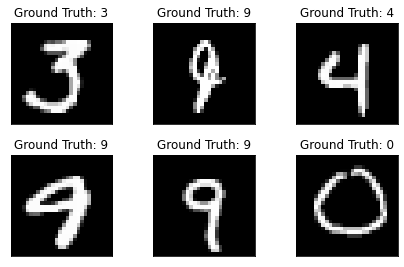

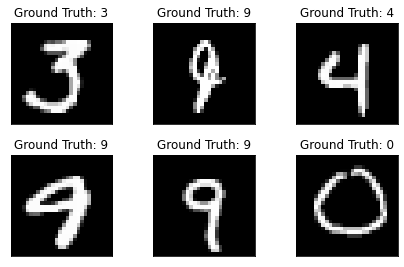

In [6]:
# untuk menampilkan nilai gambar
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [7]:
class Net(nn.Module): # untuk membuat arsitektur nn.Module
    def __init__(self): # berfungsi untuk menurunkan class
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) 
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) 
        self.conv2_drop = nn.Dropout2d() 
        self.fc1 = nn.Linear(320, 50) 
        self.fc2 = nn.Linear(50, 10) 
    def forward(self, x): # untuk menambahkan fungsi aktivasi relu, pooling, dan dropout
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training) 
        x = self.fc2(x)
        return F.log_softmax(x) # untuk fungsi aktivasi F.log_softmax

In [8]:
class Net(nn.Module): # untuk membuat arsitektur nn.Module
    def __init__(self): # berfungsi untuk menurunkan class
        super(Net, self).__init__() 
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) 
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) 
        self.conv2_drop = nn.Dropout2d() 
        self.fc1 = nn.Linear(320, 50) 
        self.fc2 = nn.Linear(50, 10) 
    def forward(self, x): # menambahkan fungsi aktivasi relu, pooling, dan dropout
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training) 
        x = self.fc2(x)
        return F.log_softmax(x) # untuk fungsi aktivasi F.log_softmax

In [9]:
network = Net() # untuk memanggil arsitektur yang telah dibuat
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum) # algortima optimasi

In [10]:
train_losses = [] # untuk mengisi train losses dengan list kosong untuk menyimpan proses training
train_counter = [] # untuk mengisi train_counter dengan list kosong yang untuk menyimpan proses training
test_losses = [] # untuk mengisi test_losses dengan list kosong untuk menyimpan proses training
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)] 

In [11]:
# Proses training data
def train(epoch): 
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [12]:
# Proses testing data
def test(): 
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [13]:
# untuk memanggil semua hasil training
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.325928
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.287777
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.281435
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.243744
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.264606
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.240564
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.153203
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.211479
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.056643
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.010620
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.008978
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.867194
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.755019
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.617704
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.411451
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.594614
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.258890
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.328231
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.236115
Train Epoch: 1 [12160/6

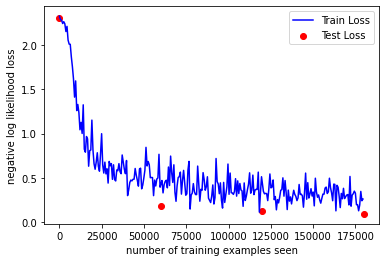

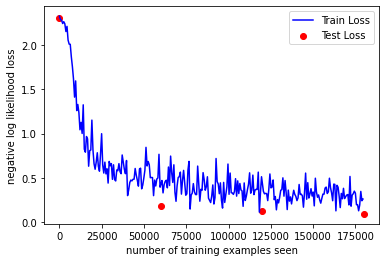

In [14]:
# untuk memvisualisasikan hasil dari plot data
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig